In [2]:
import glob
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import json
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES']='1'



In [ ]:
#每一个csv.gz文件读取 -> y已经ok ->drawing 如何处理

In [ ]:
# json

In [17]:
#单通道
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8) #画板
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img
    

In [10]:
fileList = glob.glob("./shuffle_data_gzip/*.csv.gz") 
a =json.loads(pd.read_csv(fileList[0]).loc[0,'drawing'])

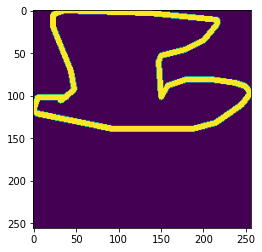

In [16]:
BASE_SIZE=256
plt.imshow(draw_cv2(a,time_color=False))
plt.show()

In [20]:
#RGB图片
# def draw_cv2(raw_strokes, size=256, lw=6):
#     img = np.zeros((BASE_SIZE, BASE_SIZE, 3), np.uint8)
#     for t, stroke in enumerate(raw_strokes):
#         points_count = len(stroke[0]) - 1
#         grad = 255//points_count
#         for i in range(len(stroke[0]) - 1):
#             _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), (255, 255 - min(t,10)*13, max(255 - grad*i, 20)), lw)
#     if size != BASE_SIZE:
#         img = cv2.resize(img, (size, size))
#     return img#

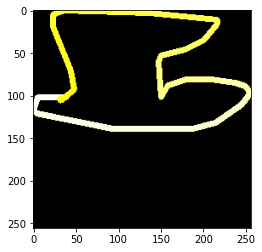

In [21]:
# plt.imshow(draw_cv2(a))

In [3]:
class DataLoader(object):
    def __init__(self, resize_height=64, resize_width=64, batch_size=512, fileList=None, size=256, lw=6):
        self.resize_height = resize_height #图片高
        self.resize_height = resize_height #图片宽
        self.batch_size = batch_size #batch
        self.fileList = fileList #文件数据
        self.size = size #画图时图片大小
        self.lw = lw

    def __call__(self):
        def _generator(size,lw):
            while True: #
                for filename in np.random.permutation(self.fileList):
                    df = pd.read_csv(filename)
                    df['drawing'] = df['drawing'].apply(json.loads)
                    x = np.zeros((len(df), size, size))
                    for i, raw_strokes in enumerate(df.drawing.values):
                        x[i] = draw_cv2(raw_strokes, size=size, lw=lw)
                    x = x / 255.
                    x = x.reshape((len(df), size, size, 1)).astype(np.float32)
                    y = tf.keras.utils.to_categorical(df.y, num_classes=n_labels)
                    for x_i,y_i in zip(x,y):
                        yield (x_i,y_i)

        dataset = tf.data.Dataset.from_generator(generator=_generator,
                                                 output_types=(tf.dtypes.float32, tf.dtypes.int32),
                                                 output_shapes=((self.resize_height, self.resize_height, 1), (340, )),
                                                 args=(self.size, self.lw))
        dataset = dataset.prefetch(buffer_size=10240)
        dataset = dataset.shuffle(buffer_size=10240).batch(self.batch_size)
        return dataset    

In [22]:
fileList = glob.glob("./shuffle_data_gzip/*.csv.gz") 

In [23]:
fileList[0]

'./shuffle_data_gzip/train_k75.csv.gz'

In [4]:
DP_DIR = './shuffle_data_gzip/'


BASE_SIZE = 256
n_labels = 340
np.random.seed(seed=1987)
size = 64
batchsize = 1024    
fileList = glob.glob("./shuffle_data_gzip/*.csv.gz") 
train_fileList = fileList[:-1]
val_fileList = fileList[-1:]
train_ds = DataLoader(resize_height=64, resize_width=64, batch_size=batchsize, fileList=train_fileList, size=size, lw=6)()    
val_ds = DataLoader(resize_height=64, resize_width=64, batch_size=batchsize, fileList=val_fileList, size=size, lw=6)()    
        
    

In [ ]:
#建模

In [6]:
inputs = tf.keras.layers.Input(shape=(size, size, 1))
base_model = tf.keras.applications.MobileNet(input_shape=(size, size, 1), include_top=False, weights=None, classes=n_labels)
x = base_model(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(n_labels, activation='softmax')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=predictions)

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.002), 
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.CategoricalCrossentropy(), 
                       tf.keras.metrics.CategoricalAccuracy(), 
                       tf.keras.metrics.TopKCategoricalAccuracy(k=3,name='top_3_categorical_accuracy')])

In [8]:
# base_model = tf.keras.applications.MobileNet(input_shape=(size, size, 1), include_top=False, weights=None, classes=n_labels)
# x = base_model.output
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(1024, activation='relu')(x)
# predictions = tf.keras.layers.Dense(n_labels, activation='softmax')(x)
# model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
mobilenet_1.00_64 (Model)    (None, 2, 2, 1024)        3228288   
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4195328   
_________________________________________________________________
dense_1 (Dense)              (None, 340)               348500    
Total params: 7,772,116
Trainable params: 7,750,228
Non-trainable params: 21,888
_________________________________________________________________


In [ ]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_top_3_categorical_accuracy', factor=0.75, patience=3, min_delta=0.001,
                          mode='max', min_lr=1e-5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('model_all.h5', monitor='val_top_3_categorical_accuracy', mode='max', save_best_only=True,
                    save_weights_only=True),
]

model.fit(
    train_ds, epochs=50, verbose=1,steps_per_epoch=48500, #一个epoch用多少个step,为了快速迭代：可以设置1000。
    validation_data = val_ds,
    validation_steps = 400,
    callbacks = callbacks
)




Train for 48500 steps, validate for 400 steps
Epoch 1/50
48500/48500 [==============================] - 21473s 443ms/step - loss: 1.0385 - categorical_crossentropy: 1.0385 - categorical_accuracy: 0.7404 - top_3_categorical_accuracy: 0.8851 - val_loss: 0.8997 - val_categorical_crossentropy: 0.8997 - val_categorical_accuracy: 0.7715 - val_top_3_categorical_accuracy: 0.9063
Epoch 2/50
23164/48500 [=============>................] - ETA: 2:52:55 - loss: 0.8529 - categorical_crossentropy: 0.8529 - categorical_accuracy: 0.7823 - top_3_categorical_accuracy: 0.9129

In [24]:
# 21473//60//60


5

In [ ]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])


In [ ]:
# test_ds =

In [ ]:
# model.predict()